In [56]:
import pandas as pd
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [57]:
data = yf.download('AAPL', '2019-01-01', '2025-01-01')
data.reset_index(inplace=True)
df=data
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
0,2019-01-02,37.667179,37.889005,36.787037,36.944462,148158800
1,2019-01-03,33.915253,34.757230,33.869933,34.342203,365248800
2,2019-01-04,35.363071,35.432244,34.299271,34.473390,234428400
3,2019-01-07,35.284363,35.499034,34.800166,35.468025,219111200
4,2019-01-08,35.956989,36.212208,35.425089,35.673149,164101200


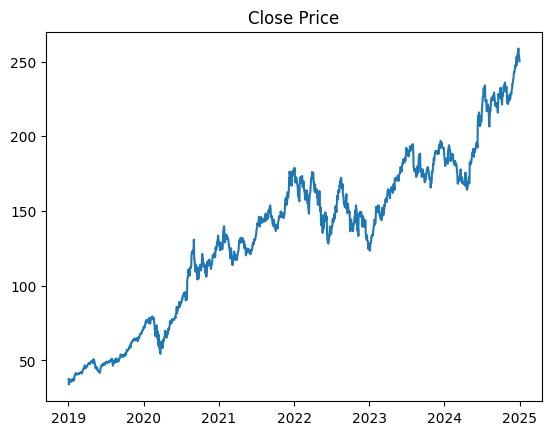

In [58]:
plt.title("Close Price")
plt.plot(df.Date, df.Close)

In [59]:
print(df.describe())

Price                            Date        Close         High          Low  \
Ticker                                        AAPL         AAPL         AAPL   
count                            1510  1510.000000  1510.000000  1510.000000   
mean    2021-12-30 20:45:27.417218304   135.145433   136.483197   133.644568   
min               2019-01-02 00:00:00    33.915253    34.757230    33.869933   
25%               2020-07-01 06:00:00    88.881508    90.234457    88.236659   
50%               2021-12-29 12:00:00   143.438828   145.019575   141.770071   
75%               2023-07-02 06:00:00   172.266022   173.789064   170.406180   
max               2024-12-31 00:00:00   258.735504   259.814335   257.347047   
std                               NaN    54.182540    54.575527    53.714585   

Price          Open        Volume  
Ticker         AAPL          AAPL  
count   1510.000000  1.510000e+03  
mean     135.000651  9.417009e+07  
min       34.342203  2.323470e+07  
25%       88.824928

In [60]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1510 entries, 0 to 1509
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   (Date, )        1510 non-null   datetime64[ns]
 1   (Close, AAPL)   1510 non-null   float64       
 2   (High, AAPL)    1510 non-null   float64       
 3   (Low, AAPL)     1510 non-null   float64       
 4   (Open, AAPL)    1510 non-null   float64       
 5   (Volume, AAPL)  1510 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 70.9 KB
None


In [61]:
df['ma100'] = df.Close.rolling(window=100).mean()
df['close_shifted'] = df.Close.shift(1)
df.dropna(inplace=True)
df


Price,Date,Close,High,Low,Open,Volume,ma100,close_shifted
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL,,
99,2019-05-24,43.036224,43.798502,42.952060,43.331997,94858800,43.237120,43.202145
100,2019-05-28,42.858280,43.425780,42.781333,43.024202,111792800,43.289031,43.036224
101,2019-05-29,42.653873,43.127592,42.322029,42.423024,113924800,43.376417,42.858280
102,2019-05-30,42.875111,43.098742,42.483150,42.790946,84873600,43.451538,42.653873
103,2019-05-31,42.098408,42.800568,42.079170,42.377346,108174400,43.519678,42.875111
...,...,...,...,...,...,...,...,...
1505,2024-12-24,257.916443,257.926411,255.009620,255.209412,23234700,229.357535,254.989655
1506,2024-12-26,258.735504,259.814335,257.347047,257.906429,27237100,229.859200,257.916443
1507,2024-12-27,255.309296,258.415896,252.782075,257.546826,42355300,230.346935,258.735504


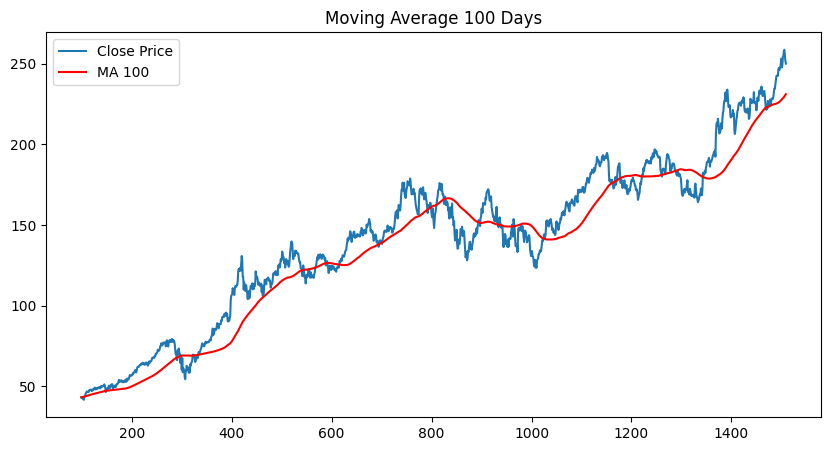

In [62]:
plt.figure(figsize=(10,5))
plt.title("Moving Average 100 Days")
plt.plot(df.Close, label="Close Price")
plt.plot(df.ma100, color='red', label="MA 100")
plt.legend()
plt.show()

In [63]:
def calculate_rsi(df, window=14):
    delta = df.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

Ticker       AAPL
112     75.572451
113     72.145387
114     74.857050
115     79.920496
116     78.061484
...           ...
1505    76.180657
1506    76.812079
1507    69.300685
1508    58.382055
1509    53.982582

[1398 rows x 1 columns]


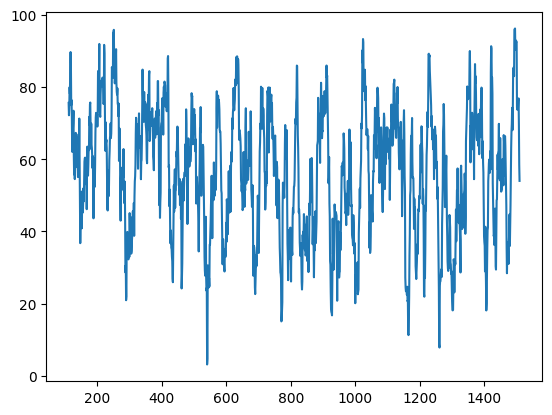

In [64]:
rsi = calculate_rsi(df.Close)
rsi = rsi.dropna()
print(rsi)

plt.plot(rsi)

In [65]:
df['day_of_week'] = df['Date'].dt.dayofweek
df['month'] = df['Date'].dt.month
df['high_low_ratio'] = df['High'] / df['Low']

In [94]:
features = ['Close','ma100','close_shifted', 'day_of_week', 'month', 'high_low_ratio']

In [95]:
scaler = MinMaxScaler(feature_range=(0,1))
df_scaled = scaler.fit_transform(df[features])


train_size = int(len(df) * 0.8)
train_data = df_scaled[:train_size]
test_data = df_scaled[train_size:]

train_data.shape, test_data.shape

((1128, 6), (283, 6))

In [ ]:
def create_sequences(scaled_data, sequence_length):
    x_data = []
    y_data = []
    
    for i in range(sequence_length, scaled_data.shape[0]):
        x_data.append(scaled_data[i-sequence_length:i, :]) 
        y_data.append(scaled_data[i, 0])

    return np.array(x_data), np.array(y_data)

sequence_length = 60
x_train, y_train = create_sequences(train_data, sequence_length)
x_test, y_test = create_sequences(test_data, sequence_length)

# Reshape pour que les données aient la forme (samples, sequence_length, features)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 6)  # Ajout de la dimension pour 'features'
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], test_data.shape[1])  # test_data.shape[1] pour avoir le bon nombre de features

print(x_train.shape)  #(samples, sequence_length, features)
print(y_train.shape)  #(samples, )

(1068, 60, 6)
(1068,)


In [130]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, activation='relu', input_shape=(x_train.shape[1], 6)))
model.add(Dropout(0.3))

model.add(LSTM(units=50, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mse')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50,
    batch_size=128,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 333ms/step - loss: 0.1298 - val_loss: 0.0585 - learning_rate: 0.0010
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - loss: 0.0289 - val_loss: 0.0454 - learning_rate: 0.0010
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 178ms/step - loss: 0.0183 - val_loss: 0.0398 - learning_rate: 0.0010
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - loss: 0.0145 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step - loss: 0.0106 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - loss: 0.0100 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 170ms/step - loss: 0.0092 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - loss: 0.0089 - val_loss: 0.0102 - learning_rate: 0.0010
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.0067
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.000500000023748

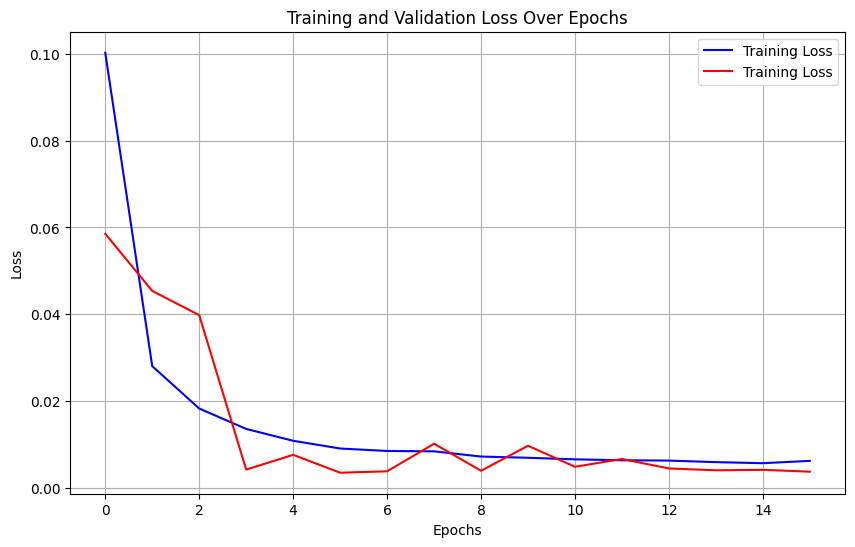

In [133]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Training Loss', color='red')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png', dpi=300)

# Show the plot
plt.show()

In [141]:
# Créer un scaler pour une seule caractéristique (si c'est une série unidimensionnelle)
scaler_single = MinMaxScaler()
scaler_single.fit(y_train.reshape(-1, 1))  # Ajuster sur y_train si y_train est la seule variable

# Inverse transform
predicted_prices = scaler_single.inverse_transform(predicted_prices)
y_test_actual = scaler_single.inverse_transform(y_test.reshape(-1, 1))


# Assurer que last_n_days a la forme correcte (1, sequence_length, 1)
last_n_days = df_scaled[-sequence_length:].reshape(1, sequence_length, 1)

# Prédiction pour les prochains jours
next_n = 30
predicted_next_n = []

for _ in range(next_n):
    next_day = model.predict(last_n_days)
    predicted_next_n.append(next_day[0, 0])  # Extraire la prédiction de la première valeur
    # Mettre à jour last_n_days en ajoutant la prédiction
    last_n_days = np.append(last_n_days[:, 1:, :], next_day.reshape(1, 1, 1), axis=1)

# Rétablir les valeurs à l'échelle originale
predicted_next_n = scaler.inverse_transform(np.array(predicted_next_n).reshape(-1, 1))


ValueError: cannot reshape array of size 360 into shape (1,60,1)

In [ ]:
# Plot the historical data and forecasted target data
plt.figure(figsize=(14, 7))

# Plot the full historical closing prices
plt.plot(df.index, data, label='Historical Prices', color='blue', alpha=0.6)

# Plot the actual closing prices from test data (this part will be part of the full data)
plt.plot(df.index[-len(y_test_actual):], y_test_actual, label='Actual Prices (Test Data)', color='blue', linestyle='--')

# Plot the predicted prices from the model (for test data)
plt.plot(df.index[-len(predicted_prices):], predicted_prices, label='Predicted Prices (Test Data)', color='red')

# Post-process the forecasted values to make sure they are non-negative
predicted_next_n[predicted_next_n < 0] = 0  # Prevent negative forecasted prices

# Plot the forecasted prices
forecast_dates = pd.date_range(df.index[-1], periods=next_n+1, freq='D')[1:]  # Generate dates for the forecast
plt.scatter(forecast_dates, predicted_next_n, label=f'Forecasted Prices (Next {next_n} Days)', color='lime', s=20, alpha=0.7)
plt.plot(forecast_dates, predicted_next_n, color='green', linestyle='-', linewidth=2)

# Customize the plot
plt.title(F'{stock_symbol} Closing Price Forecasting with LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Save plot in 300 dpi
plt.savefig(f'{stock_symbol}_forecast.png', dpi=300)

# Show the plot
plt.show()